## Chapter 4 - Time Series Anomaly Explainability

**Omni eXplainable AI (OmniXAI)** is an open-source Python library that provides XAI methods for various data types and ML models. This notebook covers a time series anomaly explainability example using a [SHAP](https://github.com/slundberg/shap) explainer provided by [OmniXAI](https://opensource.salesforce.com/OmniXAI/latest/index.html) and the [NYC taxi passengers dataset](https://www.kaggle.com/datasets/julienjta/nyc-taxi-traffic) from Kaggle. 

You can experiment with this example on [Amazon SageMaker Studio Lab](https://aws.amazon.com/sagemaker/studio-lab/), a free notebook development environment that provides up to 12 hours of CPU or 4 hours of GPU per user session and 15GiB storage at no cost. Alternatively, you can try this on your preferred Integrated Development Environment (IDE).

## Setup

In [2]:
# Install dependencies

import sys
!{sys.executable} -m pip install -qr requirements.txt

In [3]:
# Load essential libraries

%matplotlib inline

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, Dropout, TimeDistributed
import os
from platform import python_version
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
print(f'TensorFlow version: {tf.__version__}')
print(f'Python version: {python_version()}')

TensorFlow version: 2.9.2
Python version: 3.9.10


## Prepare Data
Load the NYC taxi passengers dataset which contains aggregated data at 30-minutes interval and five anomalies occur during the NYC marathon in early November, Thanksgiving, Christmas, New Years day, and a snow storm.

In [4]:
# Load dataset

data = pd.read_csv('nyc.csv')
data['date'] = pd.to_datetime(data['date'], infer_datetime_format=True)
data = pd.DataFrame.reindex(data,columns = ['date','value'])
data.head(5)

date  value
0 2014-07-01 00:00:00  10844
1 2014-07-01 00:30:00   8127
2 2014-07-01 01:00:00   6210
3 2014-07-01 01:30:00   4656
4 2014-07-01 02:00:00   3820

In [5]:
# Generate dataset statistics

data.describe()

value
count  10320.000000
mean   15137.569380
std     6939.495808
min        8.000000
25%    10262.000000
50%    16778.000000
75%    19838.750000
max    39197.000000

In [6]:
# Standardize the data

scaler = StandardScaler()
scaler.fit(data[['value']])

data['scaled_value'] = scaler.transform(data[['value']])
data.head(5)

date  value  scaled_value
0 2014-07-01 00:00:00  10844     -0.618745
1 2014-07-01 00:30:00   8127     -1.010291
2 2014-07-01 01:00:00   6210     -1.286549
3 2014-07-01 01:30:00   4656     -1.510496
4 2014-07-01 02:00:00   3820     -1.630971

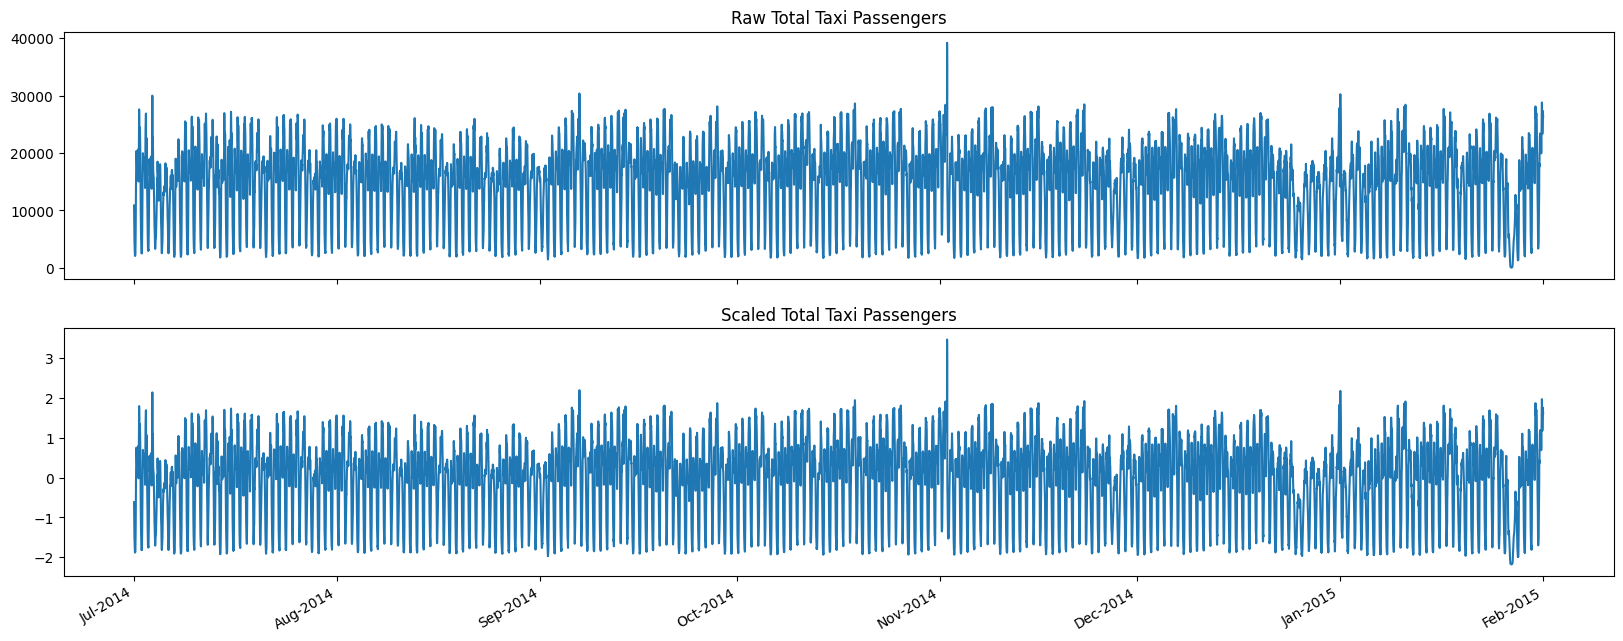

In [7]:
# Visualize raw and scaled data

x_year = data['date']
y_total = data['value']
y_scaled = data['scaled_value']

fig, axs = plt.subplots(2,sharex=False, sharey=False, figsize=(20,8))

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.minorticks_off()

axs[0].plot(x_year, y_total)
axs[0].set_title('Raw Total Taxi Passengers')

axs[1].plot(x_year, y_scaled)
axs[1].set_title('Scaled Total Taxi Passengers')

fig.autofmt_xdate()

plt.savefig('raw_scaled_ts.png', bbox_inches='tight')
plt.show()

<AxesSubplot: xlabel='value', ylabel='Count'>

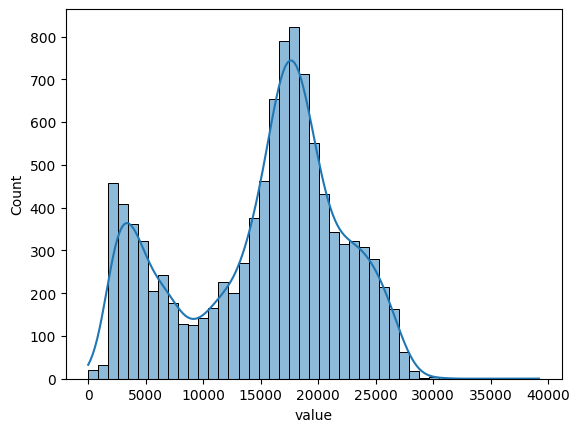

In [8]:
# Visualize dataset distribution

sns.histplot(data=data, x ='value', kde=True)

In [9]:
# Use 80% for training with hourly trend or TIMESTEPS=2

TIMESTEPS = 2

train_data, test_data = train_test_split(data, train_size=0.8, shuffle=False, random_state=42)
train_data.sort_index(inplace=True)
test_data.sort_index(inplace=True)

print(f'Train shape: {train_data.shape}')
print(f'Test shape: {test_data.shape}')

Train shape: (8256, 3)
Test shape: (2064, 3)


In [10]:
# Prepare new datasets using a pre-defined timesteps and output data shapes

def newdataset(df, timesteps, feature):
    df_x, df_y = [], []

    for i in range(timesteps, len(df)):
        df_x.append(df.iloc[i-timesteps:i][[feature]].values)
        df_y.append(df.iloc[i][feature])
    df_x = np.array(df_x)
    df_y = np.array(df_y)
    return df_x, df_y

train_x, train_y = newdataset(train_data, TIMESTEPS, 'scaled_value')
test_x, test_y = newdataset(test_data, TIMESTEPS, 'scaled_value')

train_x.shape, train_y.shape, test_x.shape, test_y.shape

((8254, 2, 1), (8254,), (2062, 2, 1), (2062,))

## Train a Model

Creating a simple LSTM model. 

In [11]:
# Build a LSTM model

LSTM_units = 64
model = keras.Sequential()
model.add(LSTM(LSTM_units, input_shape=(train_x.shape[1], train_x.shape[2]), return_sequences=False,name='encoder_lstm'))
model.add(Dropout(0.2, name='encoder_dropout'))
model.add(RepeatVector(train_x.shape[1], name='decoder_repeater'))
model.add(LSTM(LSTM_units, return_sequences=True, name='decoder_lstm'))
model.add(Dropout(rate=0.2, name='decoder_dropout'))
model.add(TimeDistributed(Dense(train_x.shape[2],name='decoder_dense_output')))

model.compile(loss='mae', optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_lstm (LSTM)         (None, 64)                16896     
                                                                 
 encoder_dropout (Dropout)   (None, 64)                0         
                                                                 
 decoder_repeater (RepeatVec  (None, 2, 64)            0         
 tor)                                                            
                                                                 
 decoder_lstm (LSTM)         (None, 2, 64)             33024     
                                                                 
 decoder_dropout (Dropout)   (None, 2, 64)             0         
                                                                 
 time_distributed (TimeDistr  (None, 2, 1)             65        
 ibuted)                                                

In [12]:
# Train a model with 20 epochs

%time 

history = model.fit(
    train_x, 
    train_x, 
    epochs=20, 
    batch_size=32, 
    validation_split=0.1, 
    shuffle=False
)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs
Epoch 1/20
233/233 [==============================] - 5s 7ms/step - loss: 0.2312 - val_loss: 0.1061
Epoch 2/20
233/233 [==============================] - 1s 4ms/step - loss: 0.1195 - val_loss: 0.1009
Epoch 3/20
233/233 [==============================] - 1s 4ms/step - loss: 0.1181 - val_loss: 0.1002
Epoch 4/20
233/233 [==============================] - 1s 4ms/step - loss: 0.1120 - val_loss: 0.0892
Epoch 5/20
233/233 [==============================] - 1s 4ms/step - loss: 0.0956 - val_loss: 0.0543
Epoch 6/20
233/233 [==============================] - 1s 4ms/step - loss: 0.0775 - val_loss: 0.0310
Epoch 7/20
233/233 [==============================] - 1s 4ms/step - loss: 0.0681 - val_loss: 0.0396
Epoch 8/20
233/233 [==============================] - 1s 4ms/step - loss: 0.0686 - val_loss: 0.0263
Epoch 9/20
233/233 [==============================] - 1s 4ms/step - loss: 0.0659 - val_loss: 0.0164
Epoch 10/20
233/233 [===============

## Evaluate Model

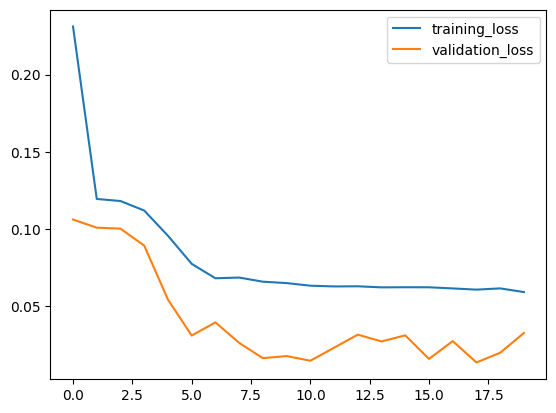

In [13]:
# Evaluate a model

plt.plot(history.history['loss'], label='training_loss')
plt.plot(history.history['val_loss'], label='validation_loss')
plt.legend()
plt.show()

## Identify Outliers

In [14]:
# Calculate reconstruction error

reconstructed = model.predict(train_x)
train_mae_loss = np.mean(np.abs(reconstructed - train_x), axis=1)

# Set a percentile threshold for reconstruction error to determine anomalies 

THRESHOLD = np.percentile(train_mae_loss, 80)
print(f'Reconstruction error threshold: {THRESHOLD}')

258/258 [==============================] - 1s 2ms/step
Reconstruction error threshold: 0.05571688195937082


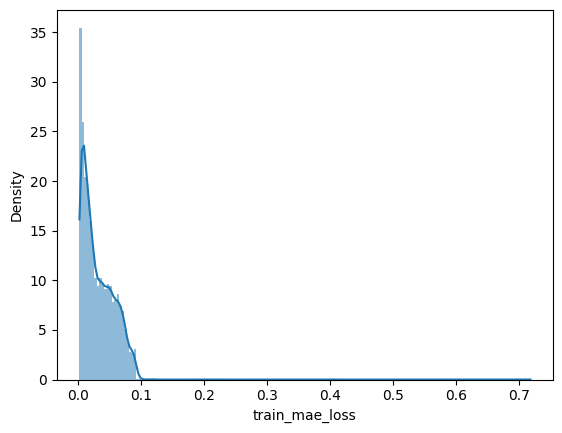

In [15]:
# Visualize train MAE distribution

sns.histplot(train_mae_loss[:,0], kde=True, stat='density', linewidth=0).set_xlabel('train_mae_loss')
plt.show()

Let's calculate the reconstruction error in the test data. A test data point will be labeled as an anomaly if it returns a reconstruction error higher than the train data point.

In [16]:
# Calculate reconstruction error in test data

test_reconstruction = model.predict(test_x)
test_mae_loss = np.mean(np.abs(test_x - test_reconstruction), axis=1)

65/65 [==============================] - 0s 2ms/step


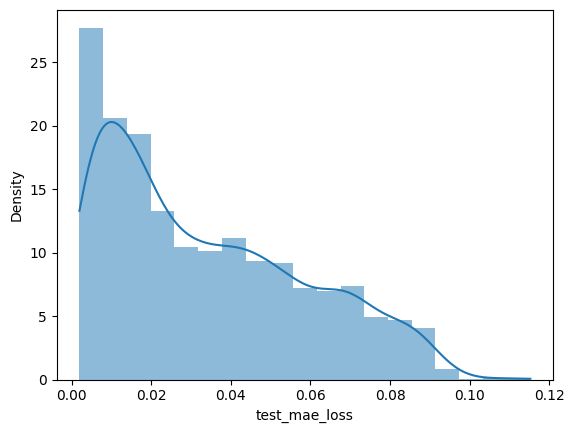

In [17]:
# Visualize test MAE distribution

sns.histplot(test_mae_loss[:,0], kde=True, stat='density', linewidth=0).set_xlabel('test_mae_loss')
plt.show()

In [18]:
# Filter outliers based on timesteps and threshold 

anomaly_results_df = test_data[TIMESTEPS:][['value', 'scaled_value']].copy()
anomaly_results_df.index = test_data[TIMESTEPS:].index

anomaly_results_df['date'] = test_data['date']
anomaly_results_df['deviation'] = test_mae_loss
anomaly_results_df['threshold'] = THRESHOLD
anomaly_results_df['anomaly'] = anomaly_results_df['deviation'].apply(lambda dev: 1 if dev > THRESHOLD else 0)

anomalies = anomaly_results_df[anomaly_results_df['anomaly'] == 1]
not_anomalies = anomaly_results_df[anomaly_results_df['anomaly'] == 0]

print(f'Total normal: {not_anomalies.shape[0]}')
print(f'Total anomalies: {anomalies.shape[0]}')

Total normal: 1617
Total anomalies: 445


In [19]:
anomalies.head(5)

value  scaled_value                date  deviation  threshold  anomaly
8258  22993      1.132044 2014-12-20 01:00:00   0.071590   0.055717        1
8259  21186      0.871637 2014-12-20 01:30:00   0.057330   0.055717        1
8267   3998     -1.605320 2014-12-20 05:30:00   0.067037   0.055717        1
8268   4080     -1.593503 2014-12-20 06:00:00   0.066583   0.055717        1
8269   5139     -1.440891 2014-12-20 06:30:00   0.066924   0.055717        1

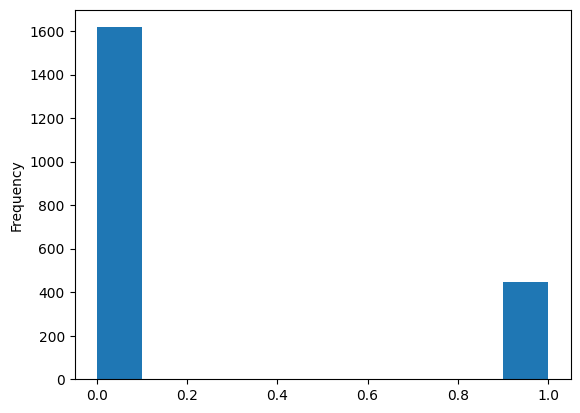

In [20]:
# Visualize anomalies distribution

anomaly_results_df['anomaly'].plot(kind='hist')
plt.show()

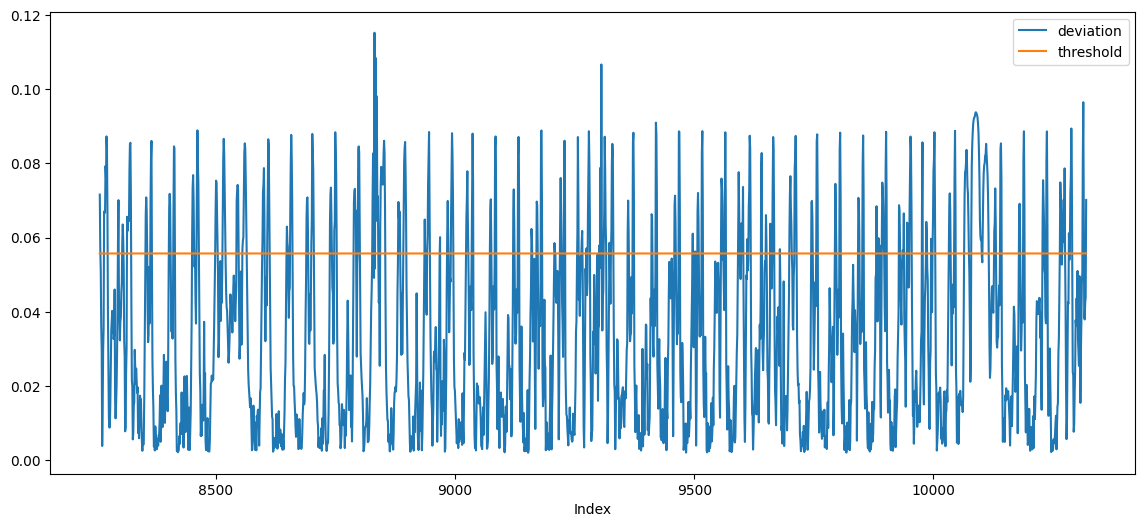

In [21]:
# Visualize deviation using test data

anomaly_results_df[['deviation', 'threshold']].plot(figsize=(14, 6))
plt.xlabel('Index')
plt.show()

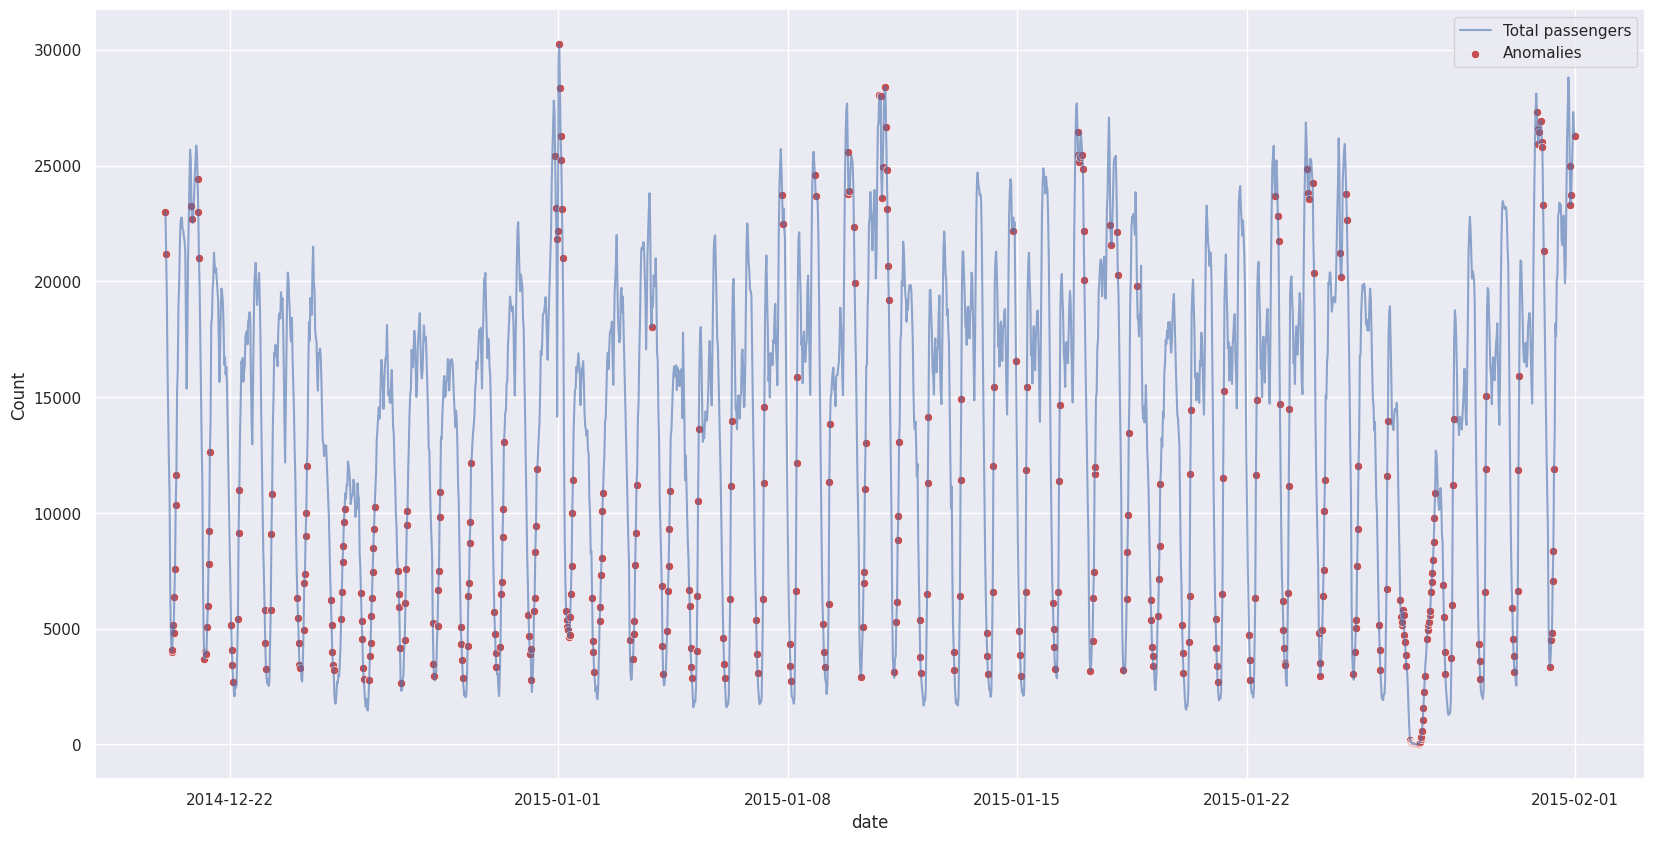

In [22]:
# Visualize identified outliers in test data

sns.set(rc={'figure.figsize':(20,10)})
sns.lineplot(x=anomaly_results_df.date, y=anomaly_results_df.value, label='Total passengers',alpha=0.6)
sns.scatterplot(x=anomalies.date, y=anomalies.value, color='r', label='Anomalies')

plt.ylabel('Count')
fig.autofmt_xdate()
plt.savefig('anomalies_vs_total.png', bbox_inches='tight')
plt.show()

## Local explanations

Here, we generate local explanations using OmniXAI's SHAP explainer.

In [23]:
# Load the OmniXAI library

from omnixai.data.timeseries import Timeseries
from omnixai.explainers.timeseries import TimeseriesExplainer
from omnixai.explainers.timeseries import ShapTimeseries

In [24]:
# Load the time series dataset

df = pd.read_csv('nyc.csv')
df = df [['date', 'value']]
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
df = df.set_index('date')

In [25]:
# Split the dataset into training and test dataset. You can modify the sample range.

train_df = df.iloc[:8600]
test_df = df.iloc[8600:9000]

# Set a threshold for detecting anomaly data points
threshold = np.percentile(train_df['value'].values, 80)

In [26]:
# Function to determine whether a time series window is anomalous

def detector(ts: Timeseries):
    anomaly_scores = np.sum((ts.values > threshold).astype(int))
    return anomaly_scores / ts.shape[0]

To initialize a SHAP explainer, set the training dataset as training_data, the model as the predict_function, and anomaly_detection as the mode. The predict_function generates anomaly scores where higher scores mean more anomalous.

In [27]:
# Initialize a SHAP explainer

explainer = ShapTimeseries(
    training_data=Timeseries.from_pd(train_df),
    predict_function=detector,
    mode='anomaly_detection'
)
test_x = Timeseries.from_pd(test_df)

SHAP generates local explanations by calling the explainer to explain the test instances. The parameter index indicates the position of a data instance in test_x. For example, index = 0 refers to the |the first instance in test_x.

  0%|          | 0/1 [00:00<?, ?it/s]

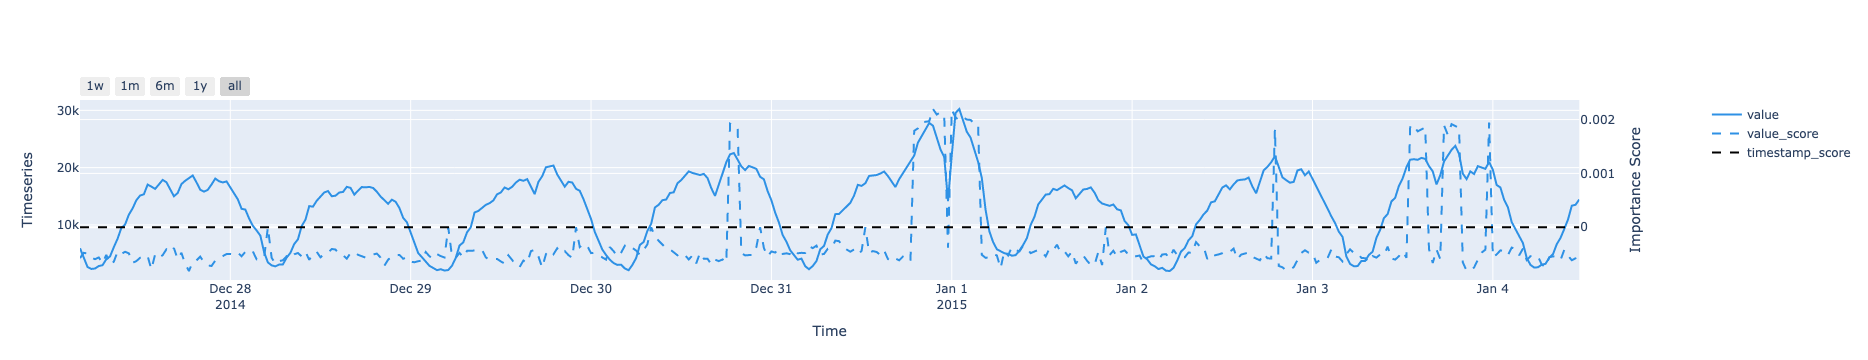

In [28]:
# Visualize local explanations. Dashed lines represent anomaly scores. A higher anomaly score shows a more abnormal datapoint. You can sample the data using nsamples setting.

explanations = explainer.explain(
    test_x
    #params={'shap': {'nsamples': 500}}
)
explanations.ipython_plot()

The chart above shows a higher importance score in dashed lines during early January, corresponding to the 2015 New Year's Day. 

This concludes a walkthrough of time series anomaly explainability using OmniXAI SHAP Explainer. Feel free to explore other XAI methods provided by [OmniXAI](https://opensource.salesforce.com/OmniXAI/latest/index.html#).